In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np 
import os
import matplotlib
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import image

### Load Data and put paths

In [ ]:
### set parent path 
path = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/'

### set location of Test.csv, Validation.csv and Train.csv within parent path
testCSV = 'data/test.csv'
validationCSV = 'data/validation.csv'
trainCSV = 'data/train.csv'

### set location of ASCfiles used for making the images within parent path
folderASC = 'ASCFiles/fase1/'


In [ ]:
### Percentage of scanpath (15%, 30%, 50%, 80% ) used for test pictures. 
percentageList = [0.15, 0.3, 0.5, 0.8]

##### Scanpath using timein miliseconds (2s, 5s, 10s,15s)
Timings= [2000, 5000, 10000, 15000] # miliseconds

In [ ]:
### load data
df_test = pd.read_csv(path + testCSV)
df_val = pd.read_csv(path + validationCSV)
df_train = pd.read_csv(path + trainCSV)

### path of ASC files
pathASC = path + folderASC

### make directories and save paths for images
pathSave_test = path + 'data/test/'
# os.mkdir(pathSave_test)

pathSave_percentage = path + 'data/test_percentages/'
# os.mkdir(pathSave_percentage)
# for percentage in percentageList:
#   os.mkdir(pathSave_percentage + 'test_' + str(int(percentage*100))+'/')

pathSave_timing = path + 'data/test_timings/'
# os.mkdir(pathSave_timing)
# for elapseTime in Timings:
#   os.mkdir(pathSave_timing +'test_' + str(int(elapseTime/1000))+'s/')

pathSave_val = path + 'data/validation/'
# os.mkdir(pathSave_val)

pathSave_train = path + 'data/train/'
# os.mkdir(pathSave_train)


### --------------------------Colormaps

In [ ]:
### maps Color
cmaps={}
cmaps['Fixations '] = ['magma','jet']
cmaps['Saccades  '] = ['winter' ]


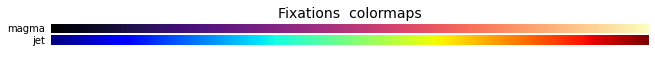

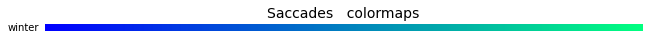

In [ ]:
### plotting color maps
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(10.5, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(name))
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()


for cmap_category, cmap_list in cmaps.items():
    plot_color_gradients(cmap_category, cmap_list)

plt.show()

### pygaze

In [ ]:
# Original copy right
# This file is part of PyGaze - the open-source toolbox for eye tracking
#
# PyGazeAnalyser is a Python module for easily analysing eye-tracking data
# Copyright (C) 2014  Edwin S. Dalmaijer
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>

# Gaze Plotter
#
# Produces different kinds of plots that are generally used in eye movement
# research, e.g. heatmaps, scanpaths, and fixation locations as overlays of
# images.
#
# version 2 (02 Jul 2014)

__author__ = "Edwin Dalmaijer"

# This current code below is a modified version of PyGaze. 
# It has been modified to fit the needs of the data analysis we needed

__modified_by__ = "Adam Peter Frederick Reynolds"

# # # # #
# LOOK

# COLOURS
# all colours are from the Tango colourmap, see:
# http://tango.freedesktop.org/Tango_Icon_Theme_Guidelines#Color_Palette
COLS = { "butter": [ '#fce94f',
     '#edd400',
     '#c4a000'],
  "orange": [ '#fcaf3e',
     '#f57900',
     '#ce5c00'],
  "chocolate": [ '#e9b96e',
     '#c17d11',
     '#8f5902'],
  "chameleon": [ '#8ae234',
     '#73d216',
     '#4e9a06'],
  "skyblue": [ '#729fcf',
     '#3465a4',
     '#204a87'],
  "plum":  [ '#ad7fa8',
     '#75507b',
     '#5c3566'],
  "scarletred":[ '#ef2929',
     '#cc0000',
     '#a40000'],
  "aluminium": [ '#eeeeec',
     '#d3d7cf',
     '#babdb6',
     '#888a85',
     '#555753',
     '#2e3436'],
  }
# SHAPE texas
SHAPE = { "veryShort":['.','b', 0.50],
          "short": ['.','r', 0.50],
    "medium": ['*', 'm', 1],
          "long":  ['p', 'y', 1.5],
          "veryLong":['X', 'w', 2]
          }

# SHAPE ROI multicolor
SHAPE_ROI = { "own":['^','blue', 1.75],
          "other": ['D','lime', 1.75],
    "outside": ['.', 'fuchsia', 1],
          }


# FONT
FONT = { 'family': 'Ubuntu',
  'size': 12}
matplotlib.rc('font', **FONT)
 

# # # # #
# FUNCTIONS

def draw_texas(fixations, saccades, fig, dispsize, originalSize, imagefile=None, loop=None, alpha=0.5, savefilename=None):
 
 """Draws images based on the paper by  Bhattacharya, N., Rakshit, S., Gwizdka, J., & Kogut, P. (2020, March).
 
 arguments
 
 fixations  - a list of fixation ending events from a single trial,
     as produced by edfreader.read_edf, e.g.
     edfdata[trialnr]['events']['Efix']

 saccades - a list of saccades events from a single trial,
     as produced by edfreader.read_edf, e.g.
     edfdata[trialnr]['events']['Esac']

 fig  - created instance of fig from plt.figure. 
     e.g fig = plt.figure( figsize = (1024,768))
 
 dispsize  - tuple or list indicating the size of the final display size,
     i.e. what dimension to display on  
     e.g. (1024,768)

 originalSize  - tuple or list indicating the size of the original display size 
     i.e. where the eyetracking data was collected from,
     e.g. (1024,768)
 
 keyword arguments
                    
 imagefile  - full path to an image file over which the scanpath can be ovelayed
     , or None for no image; NOTE: the image
     may be smaller than the display size, the function
     assumes that the image was presented at the centre of
     the display (default = None)

 loop  - for saving multiple picture. Clear figure if True (default = None) 

 alpha  - float between 0 and 1, indicating the transparancy of
     the heatmap, where 0 is completely transparant and 1
     is completely untransparant (default = 0.5)

 savefilename - full path to the file in which the heatmap should be
     saved, or None to not save the file (default = None)
 
 returns
 
 fig   - a matplotlib.plt Figure instance, containing the
     fixations
 """

 # FIXATIONS
 fix = parse_fixations(fixations)
 fix['shape'] = np.chararray(len(fixations), buffer='str')
 fix['color'] = np.chararray(len(fixations), buffer='str')
 fix['size'] = np.zeros(len(fixations))

 fix['shape'][(fix['dur'] <= 175) ]= SHAPE["short"][0]
 fix['color'][(fix['dur'] <= 175)]= SHAPE["short"][1]
 fix['size'][(fix['dur'] <= 175)] = SHAPE["short"][2]

 fix['shape'][(fix['dur'] > 175) & (fix['dur'] <= 350)]= SHAPE["medium"][0]
 fix['color'][(fix['dur'] > 175) & (fix['dur'] <= 350)]= SHAPE["medium"][1]
 fix['size'][(fix['dur'] > 175) & (fix['dur'] <= 350)] = SHAPE["medium"][2]
    
 fix['shape'][(fix['dur'] > 350) & (fix['dur'] <= 525)]= SHAPE["long"][0]
 fix['color'][(fix['dur'] > 350) & (fix['dur'] <= 525)]= SHAPE["long"][1]
 fix['size'][(fix['dur'] > 350) & (fix['dur'] <= 525)] = SHAPE["long"][2]
    
 fix['shape'][(fix['dur'] > 525)]= SHAPE["veryLong"][0]
 fix['color'][(fix['dur'] > 525)]= SHAPE["veryLong"][1]
 fix['size'][(fix['dur'] > 525)] = SHAPE["veryLong"][2]
    
 # IMAGE
 fig, ax = draw_display(fig=fig, dispsize=dispsize, imagefile=imagefile)
 # to ensure the final image is correct in aspect ratio
 extraY =(dispsize[1]-originalSize[1])/2
 extraX =(dispsize[0]-originalSize[0])/2

 # draw circles
 n = len(saccades)
 colors = pl.cm.winter(np.linspace(0,1,n))
 # SACCADES
 if saccades:
  # loop through all saccades
  i = 0
  for st, et, dur, sx, sy, ex, ey in saccades:
   # draw an line between every saccade start and ending
   ax.plot([sx+extraX,ex+extraX], [sy+extraY, ey+extraY], c=colors[i], linewidth=2)
   i += 1
 for i in range(len(fixations)):
  ax.scatter(fix['x'][i]+extraX, fix['y'][i]+extraY, s=fix['size'][i]*1000, c=fix['color'][i].decode(), 
             marker=fix['shape'][i].decode(), alpha=alpha, edgecolors='white', zorder=50)     

    # FINISH PLOT
 # invert the y axis, as (0,0) is top left on a display
 ax.invert_yaxis()
 # save the figure if a file name was provided
 if savefilename != None:
  fig.savefig(savefilename)
 if loop != None:
  fig.clf()
 return fig

def draw_scanpath_color(saccades, fig, dispsize, originalSize, cmap_saccades='winter', linewidth=2,  imagefile=None, loop=None, alpha=0.5, savefilename=None):
 """Draws a scanpath: a series of lines between fixations,
 optionally drawn over an image. 

 arguments
 
 saccades - a list of saccades events from a single trial,
     as produced by edfreader.read_edf, e.g.
     edfdata[trialnr]['events']['Esac']

 dispsize  - tuple or list indicating the size of the final display size,
     i.e. what dimension to display on  
     e.g. (1024,768)

 originalSize  - tuple or list indicating the size of the original display size 
     i.e. where the eyetracking data was collected from,
     e.g. (1024,768)

 fig  - fig of plt.fig
  
  dispsize - dispsize of image
 
 keyword arguments
  cmap_saccades  - the color map used for the saccades
  
  linewidth  - width of saccade lines

  loop  - if prodcuing multiple image loop = 'True' will clear the figure 
             after saving the images

 imagefile  - full path to an image file over which the heatmap
     is to be laid, or None for no image; NOTE: the image
     may be smaller than the display size, the function
     assumes that the image was presented at the centre of
     the display (default = None)

 alpha  - float between 0 and 1, indicating the transparancy of
     the heatmap, where 0 is completely transparant and 1
     is completely untransparant (default = 0.5)

 savefilename - full path to the file in which the heatmap should be
     saved, or None to not save the file (default = None)
 
 returns
 
 fig   - a matplotlib.plt Figure instance, containing the
     heatmap
 """
 
 # IMAGE
 fig, ax = draw_display(fig=fig, dispsize=dispsize, imagefile=imagefile)
 # to ensure the final image is correct in aspect ratio
 extraY =(dispsize[1]-originalSize[1])/2
 extraX =(dispsize[0]-originalSize[0])/2

 # get color of saccades
 n = len(saccades)
 colors = matplotlib.cm.get_cmap(cmap_saccades, n)
 # SACCADES
 if saccades:
  # loop through all saccades
  i = 0
  for st, et, dur, sx, sy, ex, ey in saccades:
   # draw an line between every saccade start and ending
   ax.plot([sx+extraX,ex+extraX], [sy+extraY, ey+extraY], c=colors(range(n))[i], linewidth=linewidth)
   i += 1
 # invert the y axis, as (0,0) is top left on a display
 ax.invert_yaxis()
 # save the figure if a file name was provided
 if savefilename != None:
  fig.savefig(savefilename)
 if loop != None:
  fig.clf()
 return fig


def draw_scanpath_fixations_color(saccades, fixations, fig, dispsize, originalSize, cmap_saccades='winter', linewidth=2, radius=108, 
                                  imagefile=None, loop=None, alpha=0.5, savefilename=None):
 
 """Draws a scanpath: a series of lines between fixations. 
    Fixaions drawn as as blue Triangle(own payoff), green Diamond(other paroff) or pink dots(everywhere else). 
    Determiend by an economic game that was played by participants.  
    optionally drawn over an image.

 arguments
 
 fixations  - a list of fixation ending events from a single trial,
     as produced by edfreader.read_edf, e.g.
     edfdata[trialnr]['events']['Efix']

 saccades - a list of saccades events from a single trial,
     as produced by edfreader.read_edf, e.g.
     edfdata[trialnr]['events']['Esac']
 
 fig  - fig of plt.fig
  
 dispsize  - tuple or list indicating the size of the final display size,
     i.e. what dimension to display on  
     e.g. (1024,1024)

 originalSize  - tuple or list indicating the size of the original display size 
     i.e. where the eyetracking data was collected from,
     e.g. (1024,768)

 keyword arguments
 cmap_saccades  - the color map used for the saccades
  
  linewidth  - width of saccade lines

  radius  - radius around the region of interest
  
  loop  - if prodcuing multiple image loop = 'True' will clear the figure 
             after saving the images

 imagefile  - full path to an image file over which the heatmap
     is to be laid, or None for no image; NOTE: the image
     may be smaller than the display size, the function
     assumes that the image was presented at the centre of
     the display (default = None)
          
 alpha  - float between 0 and 1, indicating the transparancy of
     the heatmap, where 0 is completely transparant and 1
     is completely untransparant (default = 0.5)

 savefilename - full path to the file in which the heatmap should be
     saved, or None to not save the file (default = None)
 
 returns
 
 fig   - a matplotlib.plt Figure instance, 
 """
 
 # IMAGE
 fig, ax = draw_display(fig=fig, dispsize=dispsize, imagefile=imagefile)
 # to ensure the final image is correct in aspect ratio
 extraY =(dispsize[1]-originalSize[1])/2
 extraX =(dispsize[0]-originalSize[0])/2

 # draw circles
 n = len(saccades)
 colors = matplotlib.cm.get_cmap(cmap_saccades, n)

 # SACCADES
 if saccades:
  # loop through all saccades
  i = 0
  for st, et, dur, sx, sy, ex, ey in saccades:
   # draw an line between every saccade start and ending
   ax.plot([sx+extraX,ex+extraX], [sy+extraY, ey+extraY], c=colors(range(n))[i], linewidth=linewidth)
   i += 1

 # FIXATIONS
 fix = parse_fixations(fixations)
 for i in range(len(fixations)):
   #own
   if ( ((402+extraX- radius< fix['x'][i] <402+extraX+ radius) or
         (832+extraX- radius< fix['x'][i] <832+extraX+ radius) or
         (1258+extraX- radius< fix['x'][i] <1258+extraX+ radius))& ( 
       (350+extraY- radius< fix['y'][i]+extraY <350+extraY+ radius) or 
       (615+extraY- radius< fix['y'][i]+extraY <615+extraY+ radius) or
        (880+extraY- radius< fix['y'][i]+extraY <880+extraY+ radius)  )):
      ax.scatter(fix['x'][i]+extraX, fix['y'][i]+extraY, s=SHAPE_ROI['own'][2]*1000, c=SHAPE_ROI['own'][1], 
                 marker=SHAPE_ROI['own'][0], alpha=alpha, edgecolors='white', zorder=50)
   
   #other
   elif ( ((650+extraX- radius< fix['x'][i] <650+extraX+ radius) or
           (1078+extraX- radius< fix['x'][i] <1078+extraX+ radius) or
           (1500+extraX- radius< fix['x'][i] <1500+extraX+ radius))& ( 
        (200+extraY- radius< fix['y'][i]+extraY <200+extraY+ radius) or
        (468+extraY- radius< fix['y'][i]+extraY <468+extraY+ radius) or
        (735+extraY- radius< fix['y'][i]+extraY <735+extraY+ radius)  )):
      ax.scatter(fix['x'][i]+extraX, fix['y'][i]+extraY, s=SHAPE_ROI['other'][2]*1000, c=SHAPE_ROI['other'][1], 
                 marker=SHAPE_ROI['other'][0], alpha=alpha, edgecolors='white', zorder=50)
   
   #outside
   else:
      ax.scatter(fix['x'][i]+extraX, fix['y'][i]+extraY, s=SHAPE_ROI['outside'][2]*1000, c=SHAPE_ROI['outside'][1],
                 marker=SHAPE_ROI['outside'][0], alpha=alpha, edgecolors='white', zorder=50)     

 # invert the y axis, as (0,0) is top left on a display
 ax.invert_yaxis()
 # save the figure if a file name was provided
 if savefilename != None:
  fig.savefig(savefilename)
 if loop != None:
  fig.clf()
 return fig



def draw_scanpath_fixations_AOI(saccades, fixations, fig, dispsize, originalSize, cmap_saccades='winter', cmap_fixations='magma',
                                linewidth=2, radius=108, imagefile=None, loop=None, alpha=0.5, savefilename=None):
 
 """Draws a scanpath: a series of lines between fixations. 
    Draws a single fixation in the centre of a Area of Interest(AOI) that was determiend by an economic game display
    that was played by participants.  The color of the fixations determiens numebr fo times the AOI was visited.
    AOIs are depicted by a grey background. Optionally drawn over an image.

 arguments
 
 fixations  - a list of fixation ending events from a single trial,
     as produced by edfreader.read_edf, e.g.
     edfdata[trialnr]['events']['Efix']

 saccades - a list of saccades events from a single trial,
     as produced by edfreader.read_edf, e.g.
     edfdata[trialnr]['events']['Esac']
 
 fig  - fig of plt.fig
  
 dispsize  - tuple or list indicating the size of the final display size,
     i.e. what dimension to display on  
     e.g. (1024,1024)

 originalSize  - tuple or list indicating the size of the original display size 
     i.e. where the eyetracking data was collected from,
     e.g. (1024,768)

 keyword arguments
 cmap_saccades  - the color map used for the saccades

 cmap_fixations  - the color map used for the fixations
  
  linewidth  - width of saccade lines

  radius  - radius around the region of interest
  
  loop  - if prodcuing multiple image loop = 'True' will clear the figure 
             after saving the images

 imagefile  - full path to an image file over which the heatmap
     is to be laid, or None for no image; NOTE: the image
     may be smaller than the display size, the function
     assumes that the image was presented at the centre of
     the display (default = None)
          
 alpha  - float between 0 and 1, indicating the transparancy of
     the heatmap, where 0 is completely transparant and 1
     is completely untransparant (default = 0.5)

 savefilename - full path to the file in which the heatmap should be
     saved, or None to not save the file (default = None)
 
 returns
 
 fig   - a matplotlib.plt Figure instance, 
 """
 
 # IMAGE
 fig, ax = draw_display(fig=fig, dispsize=dispsize, imagefile=imagefile)
 
 # to ensure the final image is correct in aspect ratio
 extraY =(dispsize[1]-originalSize[1])/2
 extraX =(dispsize[0]-originalSize[0])/2

 n = len(saccades)
 colors = matplotlib.cm.get_cmap(cmap_saccades, n)


 # SACCADES
 if saccades:
  # loop through all saccades
  i = 0
  for st, et, dur, sx, sy, ex, ey in saccades:
   # draw an line between every saccade start and ending
   ax.plot([sx+extraX,ex+extraX], [sy+extraY, ey+extraY], c=colors(range(n))[i], linewidth=linewidth, zorder=49)
   i += 1

 # Areas of Interest
 ownX = [402,832,1258]
 ownY = [350,615,880]
 otherX = [650,1078,1500]
 otherY = [200,468,735]

 #color map of fixations
 nlevelColors = 20
 colorsFix = matplotlib.cm.get_cmap(cmap_fixations, nlevelColors)(np.arange(nlevelColors))
 
 fix = parse_fixations(fixations)

 for coordX in range(len(ownX)):
   for coordY in range(len(ownY)):
     # plot grey circles
     circle1 = plt.Circle((ownX[coordX]+extraX,ownY[coordY]+extraY), radius, color='dimgray', zorder=48)
     ax.add_patch(circle1)
     circle2 = plt.Circle((otherX[coordX]+extraX,otherY[coordY]+extraY), radius, color='darkgray', zorder=48)
     ax.add_patch(circle2)
     # FIXATIONS
     #plot Own 
     fixOccOwn = sum( ((ownX[coordX]+extraX- radius< fix['x']+extraX) & (fix['x']+extraX <ownX[coordX]+extraY+ radius)) & 
                    ((ownY[coordY]+extraY- radius< fix['y']+extraY) & (fix['y']+extraY <ownY[coordY]+extraY+ radius)) )
     if nlevelColors > fixOccOwn > 0:
       ax.scatter(ownX[coordX]+extraX, ownY[coordY]+extraY, s=SHAPE_ROI['own'][2]*1000, color=colorsFix[fixOccOwn], 
                  marker=SHAPE_ROI['own'][0], alpha=alpha, edgecolors='white', zorder=50)
     elif fixOccOwn >= nlevelColors:
       ax.scatter(ownX[coordX]+extraX, ownY[coordY]+extraY, s=SHAPE_ROI['own'][2]*1000, color=colorsFix[nlevelColors-1], 
                  marker=SHAPE_ROI['own'][0], alpha=alpha, edgecolors='white', zorder=50)
     
     #plot Other 
     fixOccOther = sum( ((otherX[coordX]+extraX- radius< fix['x']+extraX) & (fix['x']+extraX <otherX[coordX]+extraX+ radius)) &
                      ((otherY[coordY]+extraY- radius< fix['y']+extraY) & (fix['y']+extraY <otherY[coordY]+extraY+ radius)) )  
     if nlevelColors > fixOccOther >0:
       ax.scatter(otherX[coordX]+extraX, otherY[coordY]+extraY, s=SHAPE_ROI['other'][2]*1000, color=colorsFix[fixOccOther], 
                  marker=SHAPE_ROI['other'][0], alpha=alpha, edgecolors='white', zorder=50)
     elif fixOccOther >= nlevelColors:
      ax.scatter(otherX[coordX]+extraX, otherY[coordY]+extraY, s=SHAPE_ROI['other'][2]*1000, color=colorsFix[nlevelColors-1], 
                  marker=SHAPE_ROI['other'][0], alpha=alpha, edgecolors='white', zorder=50)

#plot other, a longwinded way but I cannot seem to index the outside
 for i in range(len(fixations)):
   #own
   if ( ((402- radius< fix['x'][i] <402+ radius) or
         (832- radius< fix['x'][i] <832+ radius) or
         (1258- radius< fix['x'][i] <1258+ radius))& ( 
       (350+extraY- radius< fix['y'][i]+extraY <350+extraY+ radius) or 
       (615+extraY- radius< fix['y'][i]+extraY <615+extraY+ radius) or
        (880+extraY- radius< fix['y'][i]+extraY <880+extraY+ radius)  )):
     continue
   #other
   elif ( ((650- radius< fix['x'][i] <650+ radius) or
           (1078- radius< fix['x'][i] <1078+ radius) or
           (1500- radius< fix['x'][i] <1500+ radius))& ( 
        (200+extraY- radius< fix['y'][i]+extraY <200+extraY+ radius) or
        (468+extraY- radius< fix['y'][i]+extraY <468+extraY+ radius) or
        (735+extraY- radius< fix['y'][i]+extraY <735+extraY+ radius)  )):
     continue
   
   #outside
   else:
      ax.scatter(fix['x'][i], fix['y'][i]+extraY, s=SHAPE_ROI['outside'][2]*1000, c=SHAPE_ROI['outside'][1], 
                 marker=SHAPE_ROI['outside'][0], alpha=alpha, edgecolors='white', zorder=50)     

 # invert the y axis, as (0,0) is top left on a display
 ax.invert_yaxis()
 # save the figure if a file name was provided
 if savefilename != None:
  fig.savefig(savefilename)
 if loop != None:
  fig.clf()
 return fig




# # # # #
# HELPER FUNCTIONS


def draw_display(fig, dispsize=(1920,1080),  imagefile=None):
 
 """Returns a matplotlib.plt Figure and its axes, with a size of
 dispsize, a black background colour, and optionally with an image drawn
 onto it
 
 arguments
  fig  - fig of plt.fig
  
 dispsize  - tuple or list indicating the size of the display,
     e.g. (1024,768)
 
 keyword arguments
 
 imagefile  - full path to an image file over which the heatmap
     is to be laid, or None for no image; NOTE: the image
     may be smaller than the display size, the function
     assumes that the image was presented at the centre of
     the display (default = None)
 
 returns
 fig, ax  - matplotlib.plt Figure and its axes: field of zeros
     with a size of dispsize, and an image drawn onto it
     if an imagefile was passed
 """
 
 # construct screen (black background)
 data_type = 'float32'
 if imagefile !=None:
  _, ext = os.path.splitext(imagefile)
  ext = ext.lower()
  data_type = 'float32' if ext == '.png' else 'uint8'
 screen = np.zeros((dispsize[1],dispsize[0],3), dtype=data_type)
 # if an image location has been passed, draw the image
 if imagefile != None:
  # check if the path to the image exists
  if not os.path.isfile(imagefile):
   raise Exception("ERROR in draw_display: imagefile not found at '%s'" % imagefile)
  # load image
  img = image.imread(imagefile)
  # flip image over the horizontal axis
  # (do not do so on Windows, as the image appears to be loaded with
  # the correct side up there; what's up with that? :/)
  #if not os.name == 'nt':
  # img = np.flipud(img)
  # width and height of the image
  w, h = len(img[0]), len(img)
  # x and y position of the image on the display
  x = int(dispsize[0]/2 - w/2)
  y = int(dispsize[1]/2 - h/2)
  # draw the image on the screen
  screen[y:y+h,x:x+w,:] += img
 # dots per inch
 dpi = 100.0
 # determine the figure size in inches
 #figsize = (dispsize[0]/dpi, dispsize[1]/dpi)
 # create a figure
 #fig = plt.figure(figsize=figsize, dpi=dpi, frameon=False)
 ax = plt.Axes(fig, [0,0,1,1])
 ax.set_axis_off()
 fig.add_axes(ax)
 # plot display
 ax.axis([0,dispsize[0],0,dispsize[1]])

 ax.imshow(screen)#, origin='upper')
 
 return fig, ax




def gaussian(x, sx, y=None, sy=None):
 
 """Returns an array of np arrays (a matrix) containing values between
 1 and 0 in a 2D Gaussian distribution
 
 arguments
 x  -- width in pixels
 sx  -- width standard deviation
 
 keyword argments
 y  -- height in pixels (default = x)
 sy  -- height standard deviation (default = sx)
 """
 
 # square Gaussian if only x values are passed
 if y == None:
  y = x
 if sy == None:
  sy = sx
 # centers 
 xo = x/2
 yo = y/2
 # matrix of zeros
 M = np.zeros([y,x],dtype=float)
 # gaussian matrix
 for i in range(x):
  for j in range(y):
   M[j,i] = np.exp(-1.0 * (((float(i)-xo)**2/(2*sx*sx)) + ((float(j)-yo)**2/(2*sy*sy)) ) )

 return M


def parse_fixations(fixations):
 
 """Returns all relevant data from a list of fixation ending events
 
 arguments
 
 fixations  - a list of fixation ending events from a single trial,
     as produced by edfreader.read_edf, e.g.
     edfdata[trialnr]['events']['Efix']

 returns
 
 fix  - a dict with three keys: 'x', 'y', and 'dur' (each contain
    a np array) for the x and y coordinates and duration of
    each fixation
 """
 
 # empty arrays to contain fixation coordinates
 fix = { 'x':np.zeros(len(fixations)),
   'y':np.zeros(len(fixations)),
   'dur':np.zeros(len(fixations))}
 # get all fixation coordinates
 for fixnr in range(len( fixations)):
  stime, etime, dur, ex, ey = fixations[fixnr]
  fix['x'][fixnr] = ex
  fix['y'][fixnr] = ey
  fix['dur'][fixnr] = dur
 
 return fix


In [1]:
#@title EDF Reader
# EDF Reader
#
# Does not actually read EDFs directly, but the ASC files that are produced
# by edf2asc (SR Research). Information on saccades, fixations and blinks is
# read from the EDF, therefore based on SR Research algorithms. For optimal
# event detection, it might be better to use a different algorithm, e.g.
# Nystrom, M., & Holmqvist, K. (2010). An adaptive algorithm for fixation,
# saccade, and glissade detection in eyetracking data. Behavior Research
# Methods, 42, 188-204. doi:10.3758/BRM.42.1.188
#
# (C) Edwin Dalmaijer, 2013-2014
# edwin.dalmaijer@gmail.com
#
# version 2 (24-Apr-2014)

__author__ = "Edwin Dalmaijer"


import copy
import os.path




def replace_missing(value, missing=0.0):
 
 """Returns missing code if passed value is missing, or the passed value
 if it is not missing; a missing value in the EDF contains only a
 period, no numbers; NOTE: this function is for gaze position values
 only, NOT for pupil size, as missing pupil size data is coded '0.0'
 
 arguments
 value  - either an X or a Y gaze position value (NOT pupil
     size! This is coded '0.0')
 
 keyword arguments
 missing  - the missing code to replace missing data with
     (default = 0.0)
 
 returns
 value  - either a missing code, or a float value of the
     gaze position
 """
 
 if value.replace(' ','') == '.':
  return missing
 else:
  return float(value)

def read_edf(filename, start, stop=None, missing=0.0, debug=False):
 
 """Returns a list with dicts for every trial. A trial dict contains the
 following keys:
  x  - np array of x positions
  y  - np array of y positions
  size  - np array of pupil size
  time  - np array of timestamps, t=0 at trialstart
  trackertime - np array of timestamps, according to EDF
  events - dict with the following keys:
      Sfix - list of lists, each containing [starttime]
      Ssac - list of lists, each containing [starttime]
      Sblk - list of lists, each containing [starttime]
      Efix - list of lists, each containing [starttime, endtime, duration, endx, endy]
      Esac - list of lists, each containing [starttime, endtime, duration, startx, starty, endx, endy]
      Eblk - list of lists, each containing [starttime, endtime, duration]
      msg - list of lists, each containing [time, message]
      NOTE: timing is in EDF time!
 
 arguments
 filename  - path to the file that has to be read
 start  - trial start string
 
 keyword arguments
 stop   - trial ending string (default = None)
 missing  - value to be used for missing data (default = 0.0)
 debug  - Boolean indicating if DEBUG mode should be on or off;
    if DEBUG mode is on, information on what the script
    currently is doing will be printed to the console
    (default = False)
 
 returns
 data   - a list with a dict for every trial (see above)
 """

 # # # # #
 # debug mode
 
 if debug:
  def message(msg):
   print(msg)
 else:
  def message(msg):
   pass
  
 
 # # # # #
 # file handling
 
 # check if the file exists
 if os.path.isfile(filename):
  # open file
  message("opening file '%s'" % filename)
  f = open(filename)
 # raise exception if the file does not exist
 else:
  raise Exception("Error in read_edf: file '%s' does not exist" % filename)
 
 # read file contents
 message("reading file '%s'" % filename)
 raw = f.readlines()
 
 # close file
 message("closing file '%s'" % filename)
 f.close()

 
 # # # # #
 # parse lines
 
 # variables
 data = []
 x = []
 y = []
 size = []
 time = []
 trackertime = []
 events = {'Sfix':[],'Ssac':[],'Sblk':[],'Efix':[],'Esac':[],'Eblk':[],'msg':[]}
 starttime = 0
 started = False
 trialend = False
 finalline = raw[-1]
 
 # loop through all lines
 for line in raw:
  
  # check if trial has already started
  if started:
   # only check for stop if there is one
   if stop != None:
    if stop in line:
     started = False
     trialend = True
   # check for new start otherwise
   else:
    if (start in line) or (line == finalline):
     started = True
     trialend = True
   
   # # # # #
   # trial ending
   
   if trialend:
    message("trialend %d; %d samples found" % (len(data),len(x)))
    # trial dict
    trial = {}
    trial['x'] = np.array(x)
    trial['y'] = np.array(y)
    trial['size'] = np.array(size)
    trial['time'] = np.array(time)
    trial['trackertime'] = np.array(trackertime)
    trial['events'] = copy.deepcopy(events)
    # add trial to data
    data.append(trial)
    # reset stuff
    x = []
    y = []
    size = []
    time = []
    trackertime = []
    events = {'Sfix':[],'Ssac':[],'Sblk':[],'Efix':[],'Esac':[],'Eblk':[],'msg':[]}
    trialend = False
    
  # check if the current line contains start message
  else:
   if start in str(line):
    message("trialstart %d" % len(data))
    # set started to True
    started = True
    # find starting time
    starttime = int(line[line.find('\t')+1:line.find(' ')])
  
  # # # # #
  # parse line
  
  if started:
   # message lines will start with MSG, followed by a tab, then a
   # timestamp, a space, and finally the message, e.g.:
   # "MSG\t12345 something of importance here"
   if line[0:3] == "MSG":
    ms = line.find(" ") # message start
    t = int(line[4:ms]) # time
    m = line[ms+1:] # message
    events['msg'].append([t,m])
 
   # EDF event lines are constructed of 9 characters, followed by
   # tab separated values; these values MAY CONTAIN SPACES, but
   # these spaces are ignored by float() (thank you Python!)
     
   # fixation start
   elif line[0:4] == "SFIX":
    message("fixation start")
    l = line[9:]
    events['Sfix'].append(int(l))
   # fixation end
   elif line[0:4] == "EFIX":
    message("fixation end")
    l = line[9:]
    l = l.split('\t')
    st = int(l[0]) # starting time
    et = int(l[1]) # ending time
    dur = int(l[2]) # duration
    sx = replace_missing(l[3], missing=missing) # x position
    sy = replace_missing(l[4], missing=missing) # y position
    events['Efix'].append([st, et, dur, sx, sy])
   # saccade start
   elif line[0:5] == 'SSACC':
    message("saccade start")
    l = line[9:]
    events['Ssac'].append(int(l))
   # saccade end
   elif line[0:5] == "ESACC":
    message("saccade end")
    l = line[9:]
    l = l.split('\t')
    st = int(l[0]) # starting time
    et = int(l[1]) # endint time
    dur = int(l[2]) # duration
    sx = replace_missing(l[3], missing=missing) # start x position
    sy = replace_missing(l[4], missing=missing) # start y position
    ex = replace_missing(l[5], missing=missing) # end x position
    ey = replace_missing(l[6], missing=missing) # end y position
    events['Esac'].append([st, et, dur, sx, sy, ex, ey])
   # blink start
   elif line[0:6] == "SBLINK":
    message("blink start")
    l = line[9:]
    events['Sblk'].append(int(l))
   # blink end
   elif line[0:6] == "EBLINK":
    message("blink end")
    l = line[9:]
    l = l.split('\t')
    st = int(l[0])
    et = int(l[1])
    dur = int(l[2])
    events['Eblk'].append([st,et,dur])
   
   # regular lines will contain tab separated values, beginning with
   # a timestamp, follwed by the values that were asked to be stored
   # in the EDF and a mysterious '...'. Usually, this comes down to
   # timestamp, x, y, pupilsize, ...
   # e.g.: "985288\t  504.6\t  368.2\t 4933.0\t..."
   # NOTE: these values MAY CONTAIN SPACES, but these spaces are
   # ignored by float() (thank you Python!)
   else:
    # see if current line contains relevant data
    try:
     # split by tab
     l = line.split('\t')
     # if first entry is a timestamp, this should work
     int(l[0])
    except:
     message("line '%s' could not be parsed" % line)
     continue # skip this line

    # check missing
    if float(l[3]) == 0.0:
     l[1] = 0.0
     l[2] = 0.0
    
    # extract data
    x.append(float(l[1]))
    y.append(float(l[2]))
    size.append(float(l[3]))
    time.append(int(l[0])-starttime)
    trackertime.append(int(l[0]))
 
 
 # # # # #
 # return
 
 return data


# =============================================================================
# # DEBUG #
# if __name__ == "__main__":
#  # start: MSG 3120773 TRIALNR 8 TARX 662 TARY 643 DISX 771 DISY 233 CSTPE 0 REINFORCE 0
#  # stop: MSG 3118572 TRIALNR END 7
#  data = read_edf('1.asc', "TRIALNR", stop="TRIALNR END", debug=False)
#  
#  x = np.zeros(len(data[0]['x'])*1.5)
#  y = np.zeros(len(data[0]['y'])*1.5)
#  size = y = np.zeros(len(data[0]['size'])*1.5)
#  
#  for i in range(len(data)):
#   x[:len(data[i]['x'])] = x[:len(data[i]['x'])] + data[i]['x']
#   y[:len(data[i]['y'])] = y[:len(data[i]['y'])] + data[i]['y']
#   y[:len(data[i]['size'])] = y[:len(data[i]['size'])] + data[i]['size']
#  x = x/len(data)
#  y = y/len(data)
#  size = size/len(data)
#  
#  from matplotlib import plt
#  plt.figure()
#  plt.plot(data[0]['time'],data[0]['x'],'r')
#  plt.plot(data[0]['time'],data[0]['y'],'g')
#  plt.plot(data[0]['time'],data[0]['size'],'b')
#  
#  plt.figure()
#  plt.plot(size,'b')
#  
#  plt.figure()
#  plt.plot(x,y,'ko')
# # # # # #
# 
# =============================================================================


### For loop for image creation for **TEST**







In [ ]:
#### Loop to get ASC file names from df
ascName ={}   
n=0
for iTrial in range(df_test.shape[0]):
        if n>9:
            n=0

        if n <1:
            ascName[df_test.iloc[iTrial,5][:-6]] =[]
            name = df_test.iloc[iTrial,5][:-6]
        ascName[name].append(df_test.iloc[iTrial,5][-6:-4])
        n+=1

for i in ascName:
    for idx in range(len(ascName[i])):
        ascName[i][idx] = ascName[i][idx].replace("_","",1)  

In [ ]:
####### for loop to make images
fig = plt.figure(figsize=(1920/100,1920/100), dpi=100.0, frameon=False)
for isub, subject in enumerate(ascName):
  print('PROCCESSING '+subject)
  datafile = read_edf(pathASC+subject+'.asc', start='START',
                            stop=None, missing=0.0, debug=False)
  for idx in ascName[subject]:
      draw_scanpath_fixations_AOI(datafile[int(idx)-1]['events']['Esac'],
                                    datafile[int(idx)-1]['events']['Efix'], 
                                    fig, dispsize = (1920,1920),  originalSize = (1920,1080),  cmap_saccades= 'winter', cmap_fixations='magma',
                                     linewidth=8, radius=108, loop=True, alpha=1, savefilename=pathSave_test+str(subject)+'_'+idx+'.jpg')
 

PROCCESSING fase1_063e1
PROCCESSING fase1_070e1
PROCCESSING fase1_28e2
PROCCESSING fase1_43e1
PROCCESSING fase1_051e1
PROCCESSING fase1_74e2
PROCCESSING fase1_025e1
PROCCESSING fase1_089e1
PROCCESSING fase1_49e1
PROCCESSING fase1_064e1
PROCCESSING fase1_60e2
PROCCESSING fase1_10e2
PROCCESSING fase1_048e1
PROCCESSING fase1_055e1
PROCCESSING fase1_97e1
PROCCESSING fase1_81e1
PROCCESSING fase1_115e25
PROCCESSING fase1_46e2
PROCCESSING fase1_78e2
PROCCESSING fase1_138e22
PROCCESSING fase1_079e1
PROCCESSING fase1_122e29
PROCCESSING fase1_076e1
PROCCESSING fase1_06e2
PROCCESSING fase1_23e1


<Figure size 1920x1920 with 0 Axes>

### For loop for image creation for **Percentage**




In [ ]:
#### Loop to get ASC file names from df
ascName ={}   
n=0
for iTrial in range(df_test.shape[0]):
        if n>9:
            n=0

        if n <1:
            ascName[df_test.iloc[iTrial,5][:-6]] =[]
            name = df_test.iloc[iTrial,5][:-6]
        ascName[name].append(df_test.iloc[iTrial,5][-6:-4])
        n+=1

for i in ascName:
    for idx in range(len(ascName[i])):
        ascName[i][idx] = ascName[i][idx].replace("_","",1)  

In [ ]:
####### for loop to make images
fig = plt.figure(figsize=(1920/100,1920/100), dpi=100.0, frameon=False)

for isub, subject in enumerate(ascName):
    print('PROCCESSING '+subject)

    datafile = read_edf(pathASC+subject+'.asc', start='START',
                              stop=None, missing=0.0, debug=False)
    
    for percentage in percentageList:

      for idx in ascName[subject]:
          
          FixIndex = int(len(datafile[int(idx)-1]['events']['Efix']) *percentage)
          SacIndex = int(len(datafile[int(idx)-1]['events']['Esac']) *percentage)

          draw_scanpath_fixations_AOI(datafile[int(idx)-1]['events']['Esac'][:SacIndex],
                                     datafile[int(idx)-1]['events']['Efix'][:FixIndex], 
                                     fig, dispsize = (1920,1920),  originalSize = (1920,1080),  cmap_saccades= 'winter', cmap_fixations='magma',
                                     linewidth=8, radius=108, loop=True, alpha=1, 
                                     savefilename=pathSave_percentage+'test_'+str(int(percentage*100))+'/'+subject+'_'+idx+'.jpg')
 

PROCCESSING fase1_063e1
PROCCESSING fase1_070e1
PROCCESSING fase1_28e2
PROCCESSING fase1_43e1
PROCCESSING fase1_051e1
PROCCESSING fase1_74e2
PROCCESSING fase1_025e1
PROCCESSING fase1_089e1
PROCCESSING fase1_49e1
PROCCESSING fase1_064e1
PROCCESSING fase1_60e2
PROCCESSING fase1_10e2
PROCCESSING fase1_048e1
PROCCESSING fase1_055e1
PROCCESSING fase1_97e1
PROCCESSING fase1_81e1
PROCCESSING fase1_115e25
PROCCESSING fase1_46e2
PROCCESSING fase1_78e2
PROCCESSING fase1_138e22
PROCCESSING fase1_079e1
PROCCESSING fase1_122e29
PROCCESSING fase1_076e1
PROCCESSING fase1_06e2
PROCCESSING fase1_23e1


<Figure size 1920x1920 with 0 Axes>

### For loop for image creation for **Timings**

In [ ]:
fig = plt.figure(figsize=(1920/100,1920/100), dpi=100.0, frameon=False)
for subject in ascName:
    print('PROCCESSING '+subject)
    datafile = read_edf(pathASC+subject+'.asc', start='START',
                              stop=None, missing=0.0, debug=False)
    for elapseTime in Timings:
      for trial in ascName[subject]:

          for ifix, timepoint in enumerate(datafile[int(trial)-1]['events']['Efix']):
              
              if timepoint[1]> datafile[int(trial)-1]['events']['Efix'][0][0]+elapseTime:
                  #print('Last Fixation '+str(ifix))
                  break
          for isac, timepoint in enumerate(datafile[int(trial)-1]['events']['Esac']):
              
              if timepoint[1]> datafile[int(trial)-1]['events']['Esac'][0][0]+elapseTime:
                  #print('Last Saccade '+str(isac))
                  break

          draw_scanpath_fixations_AOI(datafile[int(trial)-1]['events']['Esac'][:isac-1],
                                    datafile[int(trial)-1]['events']['Efix'][:ifix-1],  
                                     fig, dispsize = (1920,1920),  originalSize = (1920,1080),  cmap_saccades= 'winter', cmap_fixations='magma',
                                     linewidth=8, radius=108, loop=True, alpha=1, 
                                     savefilename= pathSave_timing+'test_'+str(int(elapseTime/1000))+'s/'+subject+'_'+trial+'.jpg')
 


PROCCESSING fase1_063e1
PROCCESSING fase1_070e1
PROCCESSING fase1_28e2
PROCCESSING fase1_43e1
PROCCESSING fase1_051e1
PROCCESSING fase1_74e2
PROCCESSING fase1_025e1
PROCCESSING fase1_089e1
PROCCESSING fase1_49e1
PROCCESSING fase1_064e1
PROCCESSING fase1_60e2
PROCCESSING fase1_10e2
PROCCESSING fase1_048e1
PROCCESSING fase1_055e1
PROCCESSING fase1_97e1
PROCCESSING fase1_81e1
PROCCESSING fase1_115e25
PROCCESSING fase1_46e2
PROCCESSING fase1_78e2
PROCCESSING fase1_138e22
PROCCESSING fase1_079e1
PROCCESSING fase1_122e29
PROCCESSING fase1_076e1
PROCCESSING fase1_06e2
PROCCESSING fase1_23e1


<Figure size 1920x1920 with 0 Axes>

### For loop for image creation for **Validation**




In [ ]:
#### Loop to get ASC file names from df
ascName ={}   
n=0
for iTrial in range(df_val.shape[0]):
        if n>9:
            n=0

        if n <1:
            ascName[df_val.iloc[iTrial,5][:-6]] =[]
            name = df_val.iloc[iTrial,5][:-6]
        ascName[name].append(df_val.iloc[iTrial,5][-6:-4])
        n+=1

for i in ascName:
    for idx in range(len(ascName[i])):
        ascName[i][idx] = ascName[i][idx].replace("_","",1)  

In [ ]:
###### for loop to make images
fig = plt.figure(figsize=(1920/100,1920/100), dpi=100.0, frameon=False)
for isub, subject in enumerate(ascName):
  print('PROCCESSING '+subject)
  datafile = read_edf(pathASC+subject+'.asc', start='START',
                            stop=None, missing=0.0, debug=False)
  for idx in ascName[subject]:
        
        draw_scanpath_fixations_AOI(datafile[int(idx)-1]['events']['Esac'],
                                      datafile[int(idx)-1]['events']['Efix'],  
                                     fig, dispsize = (1920,1920),  originalSize = (1920,1080),  cmap_saccades= 'winter', cmap_fixations='magma',
                                     linewidth=8, radius=108, loop=True, alpha=1, 
                                     savefilename= pathSave_val+str(subject)+'_'+idx+'.jpg')
 


PROCCESSING fase1_16e2
PROCCESSING fase1_21e1
PROCCESSING fase1_101e1
PROCCESSING fase1_69e1
PROCCESSING fase1_59e1
PROCCESSING fase1_70e2
PROCCESSING fase1_67e1
PROCCESSING fase1_054e1
PROCCESSING fase1_106e23
PROCCESSING fase1_41e1
PROCCESSING fase1_091e1
PROCCESSING fase1_01e1
PROCCESSING fase1_82e2
PROCCESSING fase1_001e1
PROCCESSING fase1_022e1
PROCCESSING fase1_133e22
PROCCESSING fase1_26e2
PROCCESSING fase1_141e25
PROCCESSING fase1_140e24
PROCCESSING fase1_86e2
PROCCESSING fase1_062e1
PROCCESSING fase1_136e21
PROCCESSING fase1_18e2
PROCCESSING fase1_91e1
PROCCESSING fase1_068e1
PROCCESSING fase1_123e25
PROCCESSING fase1_02e2
PROCCESSING fase1_020e1
PROCCESSING fase1_85e2
PROCCESSING fase1_77e1
PROCCESSING fase1_052e1
PROCCESSING fase1_19e1
PROCCESSING fase1_097e1
PROCCESSING fase1_89e1
PROCCESSING fase1_14e2
PROCCESSING fase1_56e2
PROCCESSING fase1_109e21
PROCCESSING fase1_04e2
PROCCESSING fase1_090e1
PROCCESSING fase1_050e1
PROCCESSING fase1_113e29
PROCCESSING fase1_066e1
PROCC

<Figure size 1920x1920 with 0 Axes>

### For loop for image creation for ***Train***


In [ ]:
#### Loop to get ASC file names from df
ascName ={}   
n=0
for iTrial in range(df_train.shape[0]):
        if n>9:
            n=0

        if n <1:
            ascName[df_train.iloc[iTrial,5][:-6]] =[]
            name = df_train.iloc[iTrial,5][:-6]
        ascName[name].append(df_train.iloc[iTrial,5][-6:-4])
        n+=1

for i in ascName:
    for idx in range(len(ascName[i])):
        ascName[i][idx] = ascName[i][idx].replace("_","",1)  

In [ ]:
####### for loop to make images

fig = plt.figure(figsize=(1920/100,1920/100), dpi=100.0, frameon=False)

for isub, subject in enumerate(ascName):
  print('PROCCESSING '+subject)
  datafile = read_edf(pathASC+subject+'.asc', start='START',
                            stop=None, missing=0.0, debug=False)
  for idx in ascName[subject]:
        draw_scanpath_fixations_AOI(datafile[int(idx)-1]['events']['Esac'],
                                      datafile[int(idx)-1]['events']['Efix'],  
                                     fig, dispsize = (1920,1920),  originalSize = (1920,1080),  cmap_saccades= 'winter', cmap_fixations='magma',
                                     linewidth=8, radius=108, loop=True, alpha=1, 
                                     savefilename= pathSave_train+str(subject)+'_'+idx+'.jpg')
 

PROCCESSING fase1_72e2
PROCCESSING fase1_034e1
PROCCESSING fase1_99e100e2
PROCCESSING fase1_124e32
PROCCESSING fase1_077e1
PROCCESSING fase1_118e24
PROCCESSING fase1_060e1
PROCCESSING fase1_62e2
PROCCESSING fase1_29e1
PROCCESSING fase1_71e1
PROCCESSING fase1_019e1
PROCCESSING fase1_014e1
PROCCESSING fase1_071e1
PROCCESSING fase1_012e1
PROCCESSING fase1_15e1
PROCCESSING fase1_112e22
PROCCESSING fase1_053e1
PROCCESSING fase1_015e1
PROCCESSING fase1_38e2
PROCCESSING fase1_54e2
PROCCESSING fase1_126e24
PROCCESSING fase1_121e22
PROCCESSING fase1_88e2
PROCCESSING fase1_37e1
PROCCESSING fase1_100e1
PROCCESSING fase1_30e2
PROCCESSING fase1_036e1
PROCCESSING fase1_120e24
PROCCESSING fase1_080e1
PROCCESSING fase1_045e1
PROCCESSING fase1_137e25
PROCCESSING fase1_075e1
PROCCESSING fase1_48e2
PROCCESSING fase1_031e1
PROCCESSING fase1_129e20
PROCCESSING fase1_065e1
PROCCESSING fase1_043e1
PROCCESSING fase1_024e1
PROCCESSING fase1_039e1
PROCCESSING fase1_017e1
PROCCESSING fase1_067e1
PROCCESSING fase

<Figure size 1920x1920 with 0 Axes>

### Count number of files in each folder

In [ ]:
for base, dirs, files in os.walk(path+'data/'):
    print('Searching in : ',base)
    print('Total Files in ' + str(len(files)))

Searching in :  /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/data/
Total Files in 3
Searching in :  /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/data/test
Total Files in 250
Searching in :  /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/data/test_percentages
Total Files in 0
Searching in :  /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/data/test_percentages/test_15
Total Files in 250
Searching in :  /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/data/test_percentages/test_30
Total Files in 250
Searching in :  /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/data/test_percentages/test_50
Total Files in 250
Searching in :  /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/data/test_percentages/test_80
Total Files in 250
Search

### Visualising some data

In [ ]:
from PIL import Image
from matplotlib.gridspec import GridSpec

In [ ]:
###  list of imges in test folders 
print(os.listdir('/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/data/test'))



['fase1_063e1_1.jpg', 'fase1_063e1_2.jpg', 'fase1_063e1_3.jpg', 'fase1_063e1_5.jpg', 'fase1_063e1_6.jpg', 'fase1_063e1_7.jpg', 'fase1_063e1_8.jpg', 'fase1_063e1_9.jpg', 'fase1_063e1_10.jpg', 'fase1_063e1_11.jpg', 'fase1_070e1_3.jpg', 'fase1_070e1_5.jpg', 'fase1_070e1_6.jpg', 'fase1_070e1_9.jpg', 'fase1_070e1_10.jpg', 'fase1_070e1_11.jpg', 'fase1_070e1_12.jpg', 'fase1_070e1_13.jpg', 'fase1_070e1_14.jpg', 'fase1_070e1_15.jpg', 'fase1_28e2_1.jpg', 'fase1_28e2_2.jpg', 'fase1_28e2_5.jpg', 'fase1_28e2_9.jpg', 'fase1_28e2_10.jpg', 'fase1_28e2_11.jpg', 'fase1_28e2_12.jpg', 'fase1_28e2_13.jpg', 'fase1_28e2_14.jpg', 'fase1_28e2_15.jpg', 'fase1_43e1_2.jpg', 'fase1_43e1_3.jpg', 'fase1_43e1_5.jpg', 'fase1_43e1_6.jpg', 'fase1_43e1_7.jpg', 'fase1_43e1_9.jpg', 'fase1_43e1_10.jpg', 'fase1_43e1_11.jpg', 'fase1_43e1_12.jpg', 'fase1_43e1_14.jpg', 'fase1_051e1_1.jpg', 'fase1_051e1_2.jpg', 'fase1_051e1_3.jpg', 'fase1_051e1_4.jpg', 'fase1_051e1_5.jpg', 'fase1_051e1_9.jpg', 'fase1_051e1_10.jpg', 'fase1_051e1_

In [ ]:
imageName =  'fase1_063e1_6.jpg'

painting = Image.open(pathSave_test+imageName)
plt.figure(figsize=(10,10))
plt.imshow(painting)
plt.axis('Off')
plt.show()

### test fase1_063e1_1.jpg'

print('test_15')
plt.figure(figsize=(10,10))
painting = Image.open(pathSave_percentage+'test_15/'+imageName)
plt.imshow(painting)
plt.axis('Off')
plt.show()

print('test_30')
plt.figure(figsize=(10,10))
painting = Image.open(pathSave_percentage+'test_30/'+imageName)
plt.imshow(painting)
plt.axis('Off')
plt.show()

print('test_50')
plt.figure(figsize=(10,10))
painting = Image.open(pathSave_percentage+'test_50/'+imageName)
plt.imshow(painting)
plt.axis('Off')
plt.show()

print('test_80')
plt.figure(figsize=(10,10))
painting = Image.open(pathSave_percentage+'test_80/'+imageName)
plt.imshow(painting)
plt.axis('Off')
plt.show()

print('test_2s')
plt.figure(figsize=(10,10))
painting = Image.open(pathSave_timing+'test_2s/'+imageName)
plt.imshow(painting)
plt.axis('Off')
plt.show()

print('test_5s')
plt.figure(figsize=(10,10))
painting = Image.open(pathSave_timing+'test_5s/'+imageName)
plt.imshow(painting)
plt.axis('Off')
plt.show()

print('test_10s')
plt.figure(figsize=(10,10))
painting = Image.open(pathSave_timing+'test_10s/'+imageName)
plt.imshow(painting)
plt.axis('Off')
plt.show()

print('test_15s')
plt.figure(figsize=(10,10))
painting = Image.open(pathSave_timing+'test_15s/'+imageName)
plt.imshow(painting)
plt.axis('Off')
plt.show()

In [ ]:
###  list of imges in test folders 
print(os.listdir('/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/data/train'))

['fase1_044e1_4.jpg', 'fase1_044e1_5.jpg', 'fase1_044e1_6.jpg', 'fase1_044e1_7.jpg', 'fase1_044e1_8.jpg', 'fase1_044e1_10.jpg', 'fase1_044e1_11.jpg', 'fase1_044e1_12.jpg', 'fase1_044e1_13.jpg', 'fase1_044e1_14.jpg', 'fase1_111e21_1.jpg', 'fase1_111e21_2.jpg', 'fase1_111e21_3.jpg', 'fase1_111e21_5.jpg', 'fase1_111e21_6.jpg', 'fase1_111e21_7.jpg', 'fase1_111e21_8.jpg', 'fase1_111e21_13.jpg', 'fase1_111e21_14.jpg', 'fase1_111e21_15.jpg', 'fase1_041e1_4.jpg', 'fase1_041e1_5.jpg', 'fase1_041e1_7.jpg', 'fase1_041e1_8.jpg', 'fase1_041e1_10.jpg', 'fase1_041e1_11.jpg', 'fase1_041e1_12.jpg', 'fase1_041e1_13.jpg', 'fase1_041e1_14.jpg', 'fase1_041e1_15.jpg', 'fase1_094e1_1.jpg', 'fase1_094e1_2.jpg', 'fase1_094e1_4.jpg', 'fase1_094e1_5.jpg', 'fase1_094e1_6.jpg', 'fase1_094e1_10.jpg', 'fase1_094e1_11.jpg', 'fase1_094e1_12.jpg', 'fase1_094e1_13.jpg', 'fase1_094e1_14.jpg', 'fase1_102e1_2.jpg', 'fase1_102e1_3.jpg', 'fase1_102e1_4.jpg', 'fase1_102e1_7.jpg', 'fase1_102e1_8.jpg', 'fase1_102e1_9.jpg', 'fas

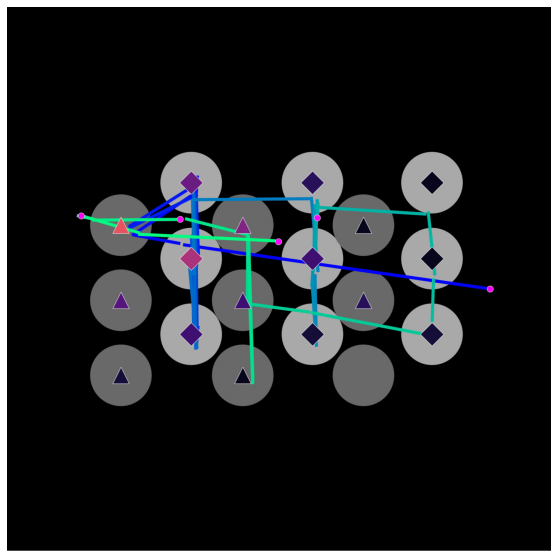

In [ ]:
painting = Image.open(pathSave_train+'fase1_07e1_13.jpg')
plt.figure(figsize=(10,10))
plt.imshow(painting)
plt.axis('Off')
plt.show()

In [ ]:
print(os.listdir('/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/data/validation'))

['fase1_16e2_2.jpg', 'fase1_16e2_3.jpg', 'fase1_16e2_4.jpg', 'fase1_16e2_7.jpg', 'fase1_16e2_8.jpg', 'fase1_16e2_11.jpg', 'fase1_16e2_12.jpg', 'fase1_16e2_13.jpg', 'fase1_16e2_14.jpg', 'fase1_16e2_15.jpg', 'fase1_21e1_1.jpg', 'fase1_21e1_2.jpg', 'fase1_21e1_3.jpg', 'fase1_21e1_6.jpg', 'fase1_21e1_7.jpg', 'fase1_21e1_9.jpg', 'fase1_21e1_10.jpg', 'fase1_21e1_11.jpg', 'fase1_21e1_12.jpg', 'fase1_21e1_13.jpg', 'fase1_101e1_2.jpg', 'fase1_101e1_3.jpg', 'fase1_101e1_4.jpg', 'fase1_101e1_7.jpg', 'fase1_101e1_9.jpg', 'fase1_101e1_10.jpg', 'fase1_101e1_11.jpg', 'fase1_101e1_12.jpg', 'fase1_101e1_13.jpg', 'fase1_101e1_15.jpg', 'fase1_69e1_3.jpg', 'fase1_69e1_4.jpg', 'fase1_69e1_6.jpg', 'fase1_69e1_7.jpg', 'fase1_69e1_8.jpg', 'fase1_69e1_9.jpg', 'fase1_69e1_10.jpg', 'fase1_69e1_12.jpg', 'fase1_69e1_14.jpg', 'fase1_69e1_15.jpg', 'fase1_59e1_3.jpg', 'fase1_59e1_5.jpg', 'fase1_59e1_6.jpg', 'fase1_59e1_8.jpg', 'fase1_59e1_10.jpg', 'fase1_59e1_11.jpg', 'fase1_59e1_12.jpg', 'fase1_59e1_13.jpg', 'fase1_

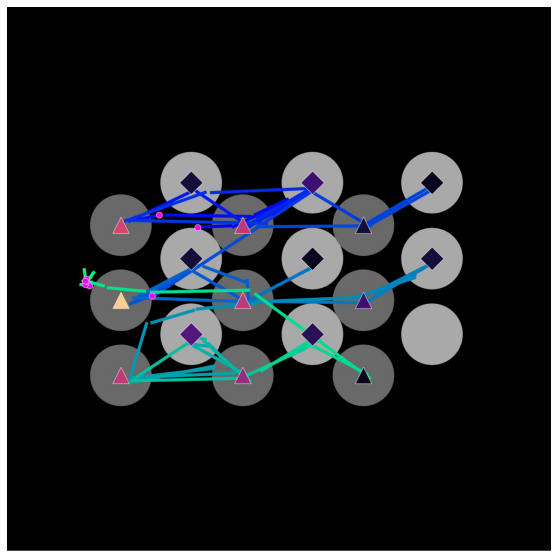

In [ ]:
painting = Image.open(pathSave_val+'fase1_16e2_4.jpg')
plt.figure(figsize=(10,10))
plt.imshow(painting)
plt.axis('Off')
plt.show()

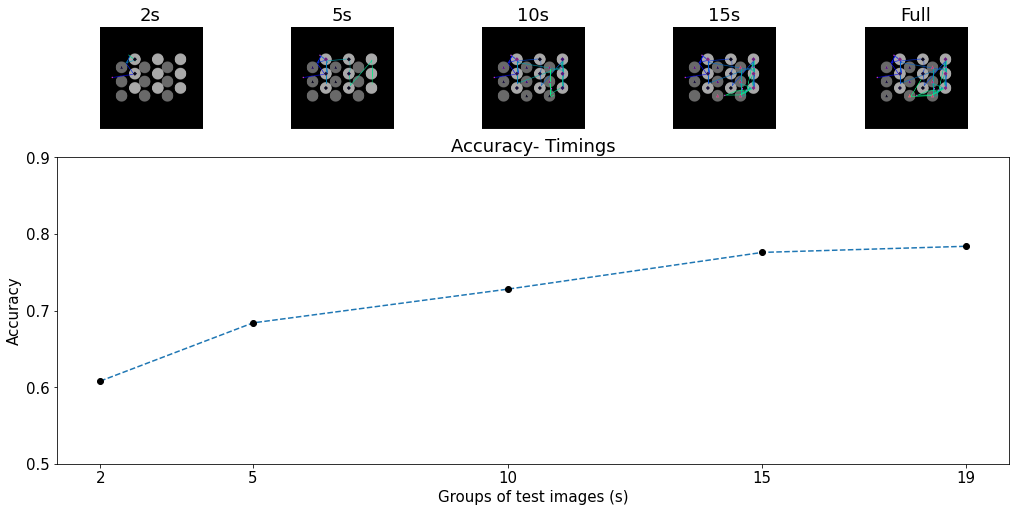

In [ ]:
acc = [0.608, 0.684, 0.728, 0.776, 0.784]				
seconds = [2, 5, 10, 15, 19]	
imageName =  'fase1_063e1_6.jpg'
plt.rcParams.update({'font.size': 15})

# create objects and grid
fig = plt.figure(constrained_layout=True, figsize=(14,7))
gs = GridSpec(4, 5, figure=fig)
 
# plot accuracy graph
ax6 = fig.add_subplot(gs[1:, :])
ax6.scatter(seconds, acc, c='k', zorder=2)
ax6.plot(seconds, acc, linestyle= '--', zorder=1)
ax6.title.set_text('Accuracy- Timings')
ax6.set_ylim(0.5,0.9)
ax6.set_xticks(ticks=seconds)
ax6.set_xticklabels( seconds)
ax6.set_yticks(ticks=np.arange(0.5, 1, 0.1))
ax6.set_ylabel('Accuracy')
ax6.set_xlabel('Groups of test images (s)')

 
# plot images
ax1 = fig.add_subplot(gs[0, 0])
img_1 = Image.open(pathSave_timing+'test_2s/'+imageName)
ax1.imshow(img_1);
ax1.title.set_text('2s');
ax1.axis('off');
    
ax2 = fig.add_subplot(gs[0, 1])
img_2 = Image.open(pathSave_timing+'test_5s/'+imageName)
ax2.imshow(img_2);
ax2.title.set_text('5s');
ax2.axis('off');

ax3 = fig.add_subplot(gs[0, 2])
img_3 = Image.open(pathSave_timing+'test_10s/'+imageName)
ax3.imshow(img_3);
ax3.title.set_text('10s');
ax3.axis('off');

ax4 = fig.add_subplot(gs[0, 3])
img_4 = Image.open(pathSave_timing+'test_15s/'+imageName)
ax4.imshow(img_4);
ax4.title.set_text('15s');
ax4.axis('off');

ax5 = fig.add_subplot(gs[0, 4])
img_full = Image.open(pathSave_test+imageName)
ax5.imshow(img_full);
ax5.title.set_text('Full');
ax5.axis('off');

plt.show()

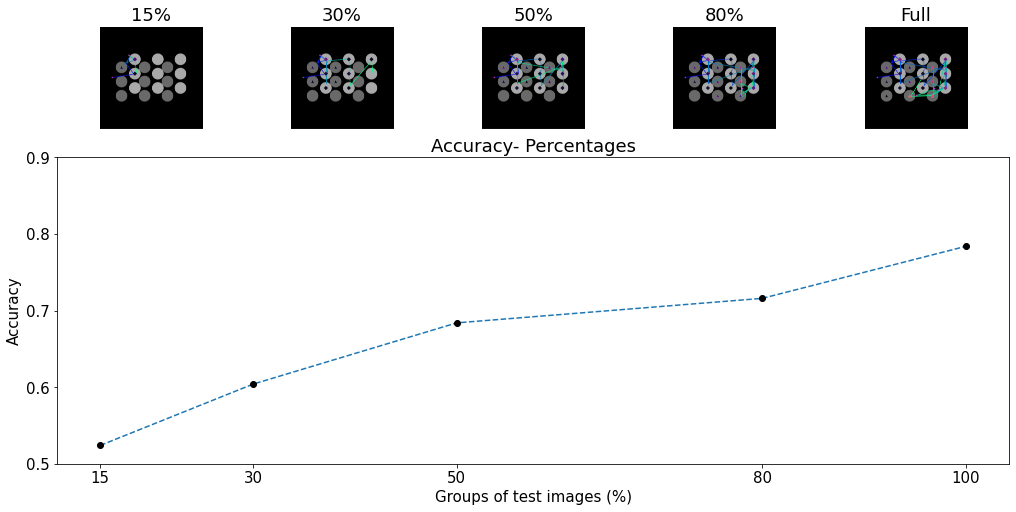

In [ ]:
acc = [0.524, 0.604, 0.684, 0.716, 0.784]				
percentage = [15, 30, 50, 80, 100]	
imageName =  'fase1_063e1_6.jpg'
plt.rcParams.update({'font.size': 15})

# create objects and grid
fig = plt.figure(constrained_layout=True, figsize=(14,7))
gs = GridSpec(4, 5, figure=fig)
 
# plot accuracy graph
ax6 = fig.add_subplot(gs[1:, :])
ax6.scatter(percentage, acc, c='k', zorder=2)
ax6.plot(percentage, acc, linestyle= '--', zorder=1)
ax6.title.set_text('Accuracy- Percentages')
ax6.set_ylim(0.5,0.9)
ax6.set_xticks(ticks=percentage)
ax6.set_xticklabels( percentage)
ax6.set_yticks(ticks=np.arange(0.5, 1, 0.1))
ax6.set_ylabel('Accuracy')
ax6.set_xlabel('Groups of test images (%)')

# plot images
ax1 = fig.add_subplot(gs[0, 0])
img_1 = Image.open(pathSave_percentage+'test_15/'+imageName)
ax1.imshow(img_1);
ax1.title.set_text('15%');
ax1.axis('off');
    
ax2 = fig.add_subplot(gs[0, 1])
img_2 = Image.open(pathSave_percentage+'test_30/'+imageName)
ax2.imshow(img_2);
ax2.title.set_text('30%');
ax2.axis('off');

ax3 = fig.add_subplot(gs[0, 2])
img_3 = Image.open(pathSave_percentage+'test_50/'+imageName)
ax3.imshow(img_3);
ax3.title.set_text('50%');
ax3.axis('off');

ax4 = fig.add_subplot(gs[0, 3])
img_4 = Image.open(pathSave_percentage+'test_80/'+imageName)
ax4.imshow(img_4);
ax4.title.set_text('80%');
ax4.axis('off');

ax5 = fig.add_subplot(gs[0, 4])
img_full = Image.open(pathSave_test+imageName)
ax5.imshow(img_full);
ax5.title.set_text('Full');
ax5.axis('off');

plt.show()